# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Define-Arguments" data-toc-modified-id="Define-Arguments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Arguments</a></div><div class="lev1 toc-item"><a href="#Check-Data" data-toc-modified-id="Check-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check Data</a></div><div class="lev1 toc-item"><a href="#Function" data-toc-modified-id="Function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function</a></div><div class="lev1 toc-item"><a href="#TESTING" data-toc-modified-id="TESTING-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TESTING</a></div><div class="lev1 toc-item"><a href="#Plot" data-toc-modified-id="Plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot</a></div><div class="lev2 toc-item"><a href="#Function:-Generate-Choice-Curves" data-toc-modified-id="Function:-Generate-Choice-Curves-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Function: Generate Choice Curves</a></div><div class="lev2 toc-item"><a href="#Function:-takeClosest" data-toc-modified-id="Function:-takeClosest-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Function: takeClosest</a></div>

# Import Libraries

In [2]:
"""
addm_mle.py
Author: Gabriela Tavares, gtavares@caltech.edu

Maximum likelihood estimation procedure for the attentional drift-diffusion
model (aDDM), using a grid search over the 3 free parameters of the model. Data
from all subjects is pooled such that a single set of optimal parameters is
estimated (or from a subset of subjects, when provided).

aDDM simulations are generated for the model with maximum estimated likelihood.
"""

import argparse
import numpy as np
import itertools
import pandas as pd

from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from bisect import bisect_left
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from addm import aDDM
from util import (load_data_from_csv, get_empirical_distributions,
                  save_simulations_to_csv, generate_choice_curves,
                  generate_rt_curves, convert_item_values)

# Define Arguments

In [3]:
class arguments:
    
    # "--subject-ids", nargs="+", type=str, default=[],
    # help= List of subject ids. If not provided, all
    # existing subjects will be used.
    subject_ids = []
        
    # "--num-threads", type=int, default=9,
    # help= Size of the thread pool.
    num_threads = 3
    
    # "--trials-per-subject", type=int, default=100,
    # help= Number of trials from each subject to be used
    # in the analysis; if smaller than 1, all trials are used.
    trials_per_subject = None  # None to use all trials?
    
    # --simulations-per-condition", type=int, default=800,
    # help= Number of artificial data trials to be
    # generated per trial condition.
    simulations_per_condition = 100
    
    # "--range-d", nargs="+", type=float, default=[0.005, 0.006, 0.007],
    # help= Search range for parameter d.
    range_d = [0.001, 0.003, 0.006]
    
    # "--range-sigma", nargs="+", type=float, default=[0.065, 0.08, 0.095],
    # help= Search range for parameter sigma.
    range_sigma = [0.03, 0.06, 0.09]
    
    # "--range-theta", nargs="+", type=float, default=[0.4, 0.5, 0.6],
    # help= Search range for parameter theta.
    range_theta = [0.1, 0.3, 0.5]
    
    # "--expdata-file-name", type=str, default="expdata.csv",
    # help= Name of experimental data file.
    expdata_file_name = "made_data/expdata.csv"
    
    # "--fixations-file-name", type=str, default="fixations.csv",
    # help= Name of fixations file.
    fixations_file_name = "made_data/fixations.csv"
    
    # "--save-simulations", default=False, action="store_true", 
    # help= Save simulations to CSV.
    save_simulations = True
    
    # "--save-figures", default=False, action="store_true", 
    # help= Save figures comparing choice and RT curves for data and simulations.
    save_figures = True
    
    # "--verbose", default=False, action="store_true",
    # help= Increase output verbosity.
    verbose = True

args = arguments()

# Check Data

In [4]:
expdata = pd.DataFrame.from_csv(args.expdata_file_name, header=0, sep=",",
                                   index_col=None)
    
left_binned_val = np.unique(expdata.item_left_val)
right_binned_val = np.unique(expdata.item_right_val)

c = list(itertools.product(left_binned_val, right_binned_val))
trialConditions = np.around(c,decimals=2)   # currently produces 81 combos

In [5]:
trialConditions

array([[-1.61, -1.65],
       [-1.61, -0.89],
       [-1.61, -0.66],
       [-1.61, -0.39],
       [-1.61,  0.02],
       [-1.61,  0.42],
       [-1.61,  0.68],
       [-1.61,  0.92],
       [-1.61,  1.69],
       [-0.89, -1.65],
       [-0.89, -0.89],
       [-0.89, -0.66],
       [-0.89, -0.39],
       [-0.89,  0.02],
       [-0.89,  0.42],
       [-0.89,  0.68],
       [-0.89,  0.92],
       [-0.89,  1.69],
       [-0.65, -1.65],
       [-0.65, -0.89],
       [-0.65, -0.66],
       [-0.65, -0.39],
       [-0.65,  0.02],
       [-0.65,  0.42],
       [-0.65,  0.68],
       [-0.65,  0.92],
       [-0.65,  1.69],
       [-0.37, -1.65],
       [-0.37, -0.89],
       [-0.37, -0.66],
       [-0.37, -0.39],
       [-0.37,  0.02],
       [-0.37,  0.42],
       [-0.37,  0.68],
       [-0.37,  0.92],
       [-0.37,  1.69],
       [ 0.03, -1.65],
       [ 0.03, -0.89],
       [ 0.03, -0.66],
       [ 0.03, -0.39],
       [ 0.03,  0.02],
       [ 0.03,  0.42],
       [ 0.03,  0.68],
       [ 0.

In [6]:
expdata.head()

,parcode,trial,rt,choice,item_left,item_right,item_left_val,item_right_val
0,1,1,8883.308377,1,1.32,1.72,1.63,1.69
1,1,2,4550.171639,1,0.38,-0.52,0.41,-0.39
2,1,3,3716.686491,1,0.96,-0.68,0.89,-0.66
3,1,4,4516.825782,-1,-0.94,0.42,-0.89,0.42
4,1,5,2966.836687,1,-0.24,0.28,-0.37,0.42


In [7]:
len(np.unique(expdata.item_right_val))

9

In [8]:
summed_vals = []
for right in right_binned_val:
    for left in left_binned_val:
        summed_vals = summed_vals + [right + left]

unique_summed_vals = np.unique(summed_vals)

In [9]:
unique_summed_vals

array([-3.26, -2.54, -2.5 , -2.3 , -2.27, -2.02, -2.  , -1.78, -1.62,
       -1.59, -1.55, -1.54, -1.31, -1.28, -1.26, -1.24, -1.19, -1.04,
       -1.03, -0.99, -0.93, -0.87, -0.86, -0.76, -0.76, -0.69, -0.63,
       -0.48, -0.47, -0.36, -0.35, -0.25, -0.23, -0.23, -0.21, -0.02,
        0.  ,  0.02,  0.03,  0.05,  0.05,  0.08,  0.23,  0.27,  0.31,
        0.43,  0.45,  0.5 ,  0.55,  0.68,  0.71,  0.74,  0.8 ,  0.83,
        0.91,  0.95,  0.97,  1.04,  1.08,  1.09,  1.24,  1.31,  1.32,
        1.33,  1.34,  1.57,  1.58,  1.65,  1.72,  1.81,  2.05,  2.1 ,
        2.31,  2.35,  2.55,  2.58,  3.32])

# Function

In [10]:
def main():

    # Load experimental data from CSV file.
    if args.verbose:
        print("Loading experimental data...")
    data = load_data_from_csv(
        args.expdata_file_name, args.fixations_file_name,
        convertItemValues=None)

    # Trial conditions with format (valueLeft, valueRight). Change this
    # according to the experiment.
    expdata = pd.DataFrame.from_csv(args.expdata_file_name, header=0, sep=",",
                                   index_col=None)
    
    left_binned_val = np.unique(expdata.item_left_val)
    right_binned_val = np.unique(expdata.item_right_val)

    c = list(itertools.product(left_binned_val, right_binned_val))
    trialConditions = np.around(c,decimals=2)   # currently produces 81 combos

    # create list of all unique summed values to be used for idx in util
    summed_vals = []
    for right in right_binned_val:
        for left in left_binned_val:
            summed_vals = summed_vals + [right + left]

    unique_summed_vals = np.unique(summed_vals)
    unique_summed_vals = np.ndarray.tolist(unique_summed_vals)
    
    # Begin maximum likelihood estimation using odd trials only.
    # Get correct subset of trials.
    dataTrials = list()
    subjectIds = args.subject_ids if args.subject_ids else data.keys()
    for subjectId in subjectIds:
        maxNumTrials = len(data[subjectId]) / 2
        numTrials = (args.trials_per_subject
                     if 1 <= args.trials_per_subject <= maxNumTrials
                     else maxNumTrials)
        trialSet = np.random.choice(
            [trialId for trialId in range(len(data[subjectId]))
             if trialId % 2],
            numTrials, replace=False)
        dataTrials.extend([data[subjectId][t] for t in trialSet])

    # Create all models to be used in the grid search.
    models = list()
    for d in args.range_d:
        for sigma in args.range_sigma:
            for theta in args.range_theta:
                models.append(aDDM(d, sigma, theta))

    # Get likelihoods for all models.
    if args.verbose:
        print("Starting grid search...")
    likelihoods = dict()
    for model in models:
        if args.verbose:
            print("Computing likelihoods for model " +
                  str(model.params) + "...")
        try:
            likelihoods[model.params] = model.parallel_get_likelihoods(
                dataTrials, numThreads=args.num_threads)
        except:
            print("An exception occurred during the likelihood " +
                  "computations for model " + str(model.params) + ".")
            raise

    # Get negative log likelihoods and optimal parameters.
    NLL = dict()
    for model in models:
        NLL[model.params] = - np.sum(np.log(likelihoods[model.params]))
    optimalParams = min(NLL, key=NLL.get)

    if args.verbose:
        print("Finished grid search!")
        print("Optimal d: " + str(optimalParams[0]))
        print("Optimal sigma: " + str(optimalParams[1]))
        print("Optimal theta: " + str(optimalParams[2]))
        print("Min NLL: " + str(min(NLL.values())))

    # Get fixation distributions from even trials.
    if args.verbose:
        print("Getting fixation distributions from even trials...")
    fixationData = get_empirical_distributions(
        data, subjectIds=subjectIds, useOddTrials=False, useEvenTrials=True)
    
    # Remove this...just want to see the middle fixations
    # ...not using a different timing for first fixation and last fixation?
    

    # Generate simulations using the even trials fixation distributions and the
    # estimated parameters.
    if args.verbose:
        print("Generating model simulations...")
    model = aDDM(*optimalParams)
    simulTrials = list()
    for (valueLeft, valueRight) in trialConditions:
        for s in xrange(args.simulations_per_condition):
            try:
                simulTrials.append(
                    model.simulate_trial(valueLeft, valueRight, fixationData))
            except:
                print("An exception occurred while generating artificial " +
                      "trial " + str(s) + " for condition (" + str(valueLeft) +
                      ", " + str(valueRight) + ").")
                raise

    currTime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

    if args.save_simulations:
        save_simulations_to_csv(simulTrials,
                                "outputs/simul_expdata_" + currTime + ".csv",
                                "outputs/simul_fixations_" + currTime + ".csv")
    # added this to test the plotting of figures
    return dataTrials, simulTrials, fixationData

    if args.save_figures:
        pdfPages = PdfPages("outputs/addm_fit_" + currTime + ".pdf")
        generate_choice_curves(dataTrials, simulTrials, pdfPages)
        generate_rt_curves(dataTrials, simulTrials, pdfPages)
        pdfPages.close()
        
        

#if __name__ == "__main__":
#    main()


In [11]:
dataTrials, simulTrials, fixationData = main()

Loading experimental data...
Starting grid search...
Computing likelihoods for model (0.001, 0.03, 0.1)...
Computing likelihoods for model (0.001, 0.03, 0.3)...
Computing likelihoods for model (0.001, 0.03, 0.5)...
Computing likelihoods for model (0.001, 0.06, 0.1)...
Computing likelihoods for model (0.001, 0.06, 0.3)...
Computing likelihoods for model (0.001, 0.06, 0.5)...
Computing likelihoods for model (0.001, 0.09, 0.1)...
Computing likelihoods for model (0.001, 0.09, 0.3)...
Computing likelihoods for model (0.001, 0.09, 0.5)...
Computing likelihoods for model (0.003, 0.03, 0.1)...
Computing likelihoods for model (0.003, 0.03, 0.3)...
Computing likelihoods for model (0.003, 0.03, 0.5)...
Computing likelihoods for model (0.003, 0.06, 0.1)...
Computing likelihoods for model (0.003, 0.06, 0.3)...
Computing likelihoods for model (0.003, 0.06, 0.5)...
Computing likelihoods for model (0.003, 0.09, 0.1)...
Computing likelihoods for model (0.003, 0.09, 0.3)...
Computing likelihoods for mod

# TESTING

In [25]:
data = load_data_from_csv(
        args.expdata_file_name, args.fixations_file_name,
        convertItemValues=None)

In [26]:
subjectIds = args.subject_ids if args.subject_ids else data.keys()

In [32]:
all_summed_vals = np.ndarray.tolist(unique_summed_vals)

In [33]:
"""valuediffs: valueDiffs: list of integers. If fixDistType is 'difficulty' or
        'fixation', valueDiffs is a range correspoding to the item values to
        be used when indexing the fixation distributions.""" 

fixationData = get_empirical_distributions(
        data, valueDiffs = all_summed_vals, subjectIds=subjectIds, useOddTrials=False, useEvenTrials=True)

In [46]:
optimalParams = [0.001, 0.06, 0.1]

In [47]:
model = aDDM(*optimalParams)
simulTrials = list()
for (valueLeft, valueRight) in trialConditions:
    for s in xrange(args.simulations_per_condition):
        try:
            simulTrials.append(
                model.simulate_trial(valueLeft, valueRight, fixationData))
        except:
            print("An exception occurred while generating artificial " +
                  "trial " + str(s) + " for condition (" + str(valueLeft) +
                  ", " + str(valueRight) + ").")
            raise

Left:  -1.61
Right:  -1.65
Left:  -1.61
Right:  -0.89
Left:  -1.61
Right:  -0.66
Left:  -1.61
Right:  -0.39
Left:  -1.61
Right:  0.02
Left:  -1.61
Right:  0.42
Left:  -1.61
Right:  0.68
Left:  -1.61
Right:  0.92
Left:  -1.61
Right:  1.69
Left:  -0.89
Right:  -1.65
Left:  -0.89
Right:  -0.89
Left:  -0.89
Right:  -0.66
Left:  -0.89
Right:  -0.39
Left:  -0.89
Right:  0.02
Left:  -0.89
Right:  0.42
Left:  -0.89
Right:  0.68
Left:  -0.89
Right:  0.92
Left:  -0.89
Right:  1.69
Left:  -0.65
Right:  -1.65
Left:  -0.65
Right:  -0.89
Left:  -0.65
Right:  -0.66
Left:  -0.65
Right:  -0.39
Left:  -0.65
Right:  0.02
Left:  -0.65
Right:  0.42
Left:  -0.65
Right:  0.68
Left:  -0.65
Right:  0.92
Left:  -0.65
Right:  1.69
Left:  -0.37
Right:  -1.65
Left:  -0.37
Right:  -0.89
Left:  -0.37
Right:  -0.66
Left:  -0.37
Right:  -0.39
Left:  -0.37
Right:  0.02
Left:  -0.37
Right:  0.42
Left:  -0.37
Right:  0.68
Left:  -0.37
Right:  0.92
Left:  -0.37
Right:  1.69
Left:  0.03
Right:  -1.65
Left:  0.03
Right:  -0

In [48]:
currTime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

save_simulations_to_csv(simulTrials,
                        "outputs/simul_expdata_" + currTime + ".csv",
                        "outputs/simul_fixations_" + currTime + ".csv")

# Plot

In [11]:
dataTrials[0].valueLeft

NameError: name 'dataTrials' is not defined

In [13]:
simulTrials[2000].valueLeft

-0.65000000000000002

In [49]:
currTime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
pdfPages = PdfPages("outputs/addm_fit_" + currTime + ".pdf")

In [50]:
generate_choice_curves(dataTrials, simulTrials, pdfPages)

In [ ]:
generate_rt_curves(dataTrials, simulTrials, pdfPages)
pdfPages.close()

## Function: Generate Choice Curves

In [1]:
def generate_choice_curves(dataTrials, simulTrials, pdfPages):
    """
    Plots the psychometric choice curves for data and simulations.
    Args:
      dataTrials: a list of aDDMTrial objects corresponding to the experimental
          data.
      simulTrials: a list of aDDMTrial objects corresponding to the
          simulations.
      pdfPages: matplotlib.backends.backend_pdf.PdfPages object.
    """

    # i think this is the number of bins and should be reduced as is currently 77
    # e.g. binNum = 9
    all_summed_vals = np.ndarray.tolist(unique_summed_vals)
    countTotal = np.zeros(len(all_summed_vals)) 
    countLeftChosen = np.zeros(len(all_summed_vals))

    for trial in dataTrials:
        # changed to ADDITION 
        # using custom helper function takeClosest(sorted_list_of_numbers, number_to_match_to_list)
        valueDiff = takeClosest(left_binned_val, trial.valueLeft) + takeClosest(right_binned_val, trial.valueRight) 
        # maybe create a list of 10-20 valueDiff ranges...could use mean of the left/right values (9 of each)
        idx = all_summed_vals.index(valueDiff)
        if trial.choice == -1:  # Choice was left REJECT.
            countLeftChosen[idx] +=1
            countTotal[idx] += 1
        elif trial.choice == 1:  # Choice was right ACCEPT.
            countTotal[idx] += 1

    stdProbLeftChosen = np.zeros(len(all_summed_vals))
    probLeftChosen = np.zeros(len(all_summed_vals))
    for i in xrange(0,len(all_summed_vals)):
        probLeftChosen[i] = countLeftChosen[i] / countTotal[i]
        stdProbLeftChosen[i] = np.sqrt(
            (probLeftChosen[i] * (1 - probLeftChosen[i])) / countTotal[i])

    colors = cm.rainbow(np.linspace(0, 1, 9))
    fig = plt.figure()
    plt.errorbar(all_summed_vals, probLeftChosen, yerr=stdProbLeftChosen,
                 color=colors[0], label="Data")

    countTotal = np.zeros(len(all_summed_vals))
    countLeftChosen = np.zeros(len(all_summed_vals))

    for trial in simulTrials:
        valueDiff = trial.valueLeft + trial.valueRight # changed to ADDITION
        idx = all_summed_vals.index(valueDiff)
        if trial.choice == -1:  # Choice was REJECT.
            countLeftChosen[idx] +=1
            countTotal[idx] += 1
        elif trial.choice == 1:  # Choice was ACCEPT.
            countTotal[idx] += 1

    stdProbLeftChosen = np.zeros(len(all_summed_vals))
    probLeftChosen = np.zeros(len(all_summed_vals))
    for i in xrange(0,len(all_summed_vals)):
        probLeftChosen[i] = countLeftChosen[i] / countTotal[i]
        stdProbLeftChosen[i] = np.sqrt(
            (probLeftChosen[i] * (1 - probLeftChosen[i])) / countTotal[i])

    plt.errorbar(all_summed_vals, probLeftChosen, yerr=stdProbLeftChosen,
                 color=colors[5], label="Simulations")
    plt.xlabel("Value difference")
    plt.ylabel("P(Reject)")  # changed from chose Left
    plt.legend()

    pdfPages.savefig(fig)
    plt.close(fig)

## Function: takeClosest

In [18]:
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [56]:
class arguments:
    mean = 0.05
    sigma = 0.25
    barrier_size = 1
    barrier_decay = 0
    state_step = 0.1
    max_time = 200
    display_figures = True

args = arguments()

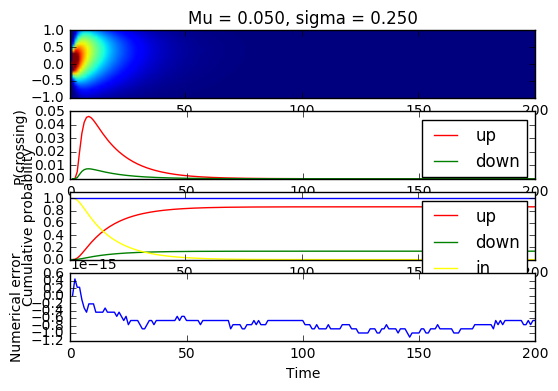

In [57]:
#!/usr/bin/python

"""
demo.py
Author: Gabriela Tavares, gtavares@caltech.edu

Demo of the attentional drift-diffusion model (aDDM), as described by Krajbich
set al. (2010).
"""

import argparse
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm


def main():

    initialBarrierUp = args.barrier_size
    initialBarrierDown = -args.barrier_size

    # The values of the barriers can change over time.
    barrierUp = initialBarrierUp * np.ones(args.max_time)
    barrierDown = initialBarrierDown * np.ones(args.max_time)
    for t in xrange(1, args.max_time):
        barrierUp[t] = initialBarrierUp / (1 + args.barrier_decay * (t + 1))
        barrierDown[t] = (initialBarrierDown /
                          (1 + args.barrier_decay * (t + 1)))

    # Obtain correct state step.
    approxStateStep = args.state_step
    halfNumStateBins = np.ceil(args.barrier_size / float(approxStateStep))
    stateStep = args.barrier_size / float(halfNumStateBins + 0.5)

    # The vertical axis is divided into states.
    states = np.arange(initialBarrierDown + (stateStep / 2.),
                       initialBarrierUp - (stateStep / 2.) + stateStep,
                       stateStep)

    # Initial probability for all states is zero, except the zero state, for
    # which the initial probability is one.
    prStates = np.zeros((states.size, args.max_time))
    prStates[np.where(states==0)[0], 0] = 1

    probUpCrossing = np.zeros(args.max_time)
    probDownCrossing = np.zeros(args.max_time)

    for t in xrange(1, args.max_time):
        prStatesNew = np.zeros(states.size)
        
        # Update the probability of the states that remain inside the barriers.
        for s in xrange(0,states.size):
            currState = states[s]
            if currState > barrierDown[t] and currState < barrierUp[t]:
                change = (currState * np.ones(states.size)) - states
                # The probability of being in state B is the sum, over all
                # states A, of the probability of being in A at the previous
                # time step times the probability of changing from A to B. We
                # multiply the probability by the state step to ensure that the
                # area under the curve for the probability distributions
                # probUpCrossing and probDownCrossing each add up to 1.
                prStatesNew[s] = (args.state_step * np.sum(
                    np.multiply(prStates[:,t-1],
                    norm.pdf(change, args.mean, args.sigma))))

        # Calculate the probabilities of crossing the up barrier and the down
        # barrier. This is given by the sum, over all states A, of the
        # probability of being in A at the previous timestep times the
        # probability of crossing the barrier if A is the previous state.
        changeUp = (barrierUp[t] * np.ones(states.size)) - states
        tempUpCross = np.sum(
            np.multiply(prStates[:,t-1],
            1 - norm.cdf(changeUp, args.mean, args.sigma)))
        changeDown = (barrierDown[t] * np.ones(states.size)) - states
        tempDownCross = np.sum(
            np.multiply(prStates[:,t-1],
                        norm.cdf(changeDown, args.mean, args.sigma)))

        # Renormalize to cope with numerical approximation.
        sumIn = np.sum(prStates[:,t-1])
        sumCurrent = np.sum(prStatesNew) + tempUpCross + tempDownCross
        prStatesNew = prStatesNew * sumIn / sumCurrent
        tempUpCross = tempUpCross * sumIn / sumCurrent
        tempDownCross = tempDownCross * sumIn / sumCurrent

        # Update the probabilities of each state and the probabilities of
        # crossing each barrier at this timestep. Note that the probabilities
        # at each time step DO NOT add up to 1. These probabilities account
        # only for the probability of the signal staying inside the barriers or
        # crossing a barrier at this time step, but not the probability of
        # already having crossed a barrier at an earlier time.
        prStates[:,t] = prStatesNew
        probUpCrossing[t] = tempUpCross
        probDownCrossing[t] = tempDownCross

    if args.display_figures:
        # Choose a suitable normalization constant.
        maxProb = max(prStates[:,3])

        plt.subplot(4, 1, 1)
        plt.imshow(prStates[::-1,:], extent=[1, args.max_time,
                                            -args.barrier_size,
                                             args.barrier_size],
                   aspect="auto", vmin=0, vmax=maxProb)
        plt.title("Mu = %.3f, sigma = %.3f" % (args.mean, args.sigma))

        plt.subplot(4, 1, 2)
        plt.plot(range(1, args.max_time + 1), probUpCrossing, label="up",
                 color="red")
        plt.plot(range(1, args.max_time + 1), probDownCrossing, label="down",
                 color="green")
        plt.xlabel("Time")
        plt.ylabel("P(crossing)")
        plt.legend()

        plt.subplot(4, 1, 3)
        probInner = np.sum(prStates, 0)
        probUp = np.cumsum(probUpCrossing)
        probDown = np.cumsum(probDownCrossing)
        probTotal = probInner + probUp + probDown
        plt.plot(range(1, args.max_time + 1), probUp, color="red",
                 label="up")
        plt.plot(range(1, args.max_time + 1), probDown, color="green",
                 label="down")
        plt.plot(range(1, args.max_time + 1), probInner, color="yellow",
                 label="in")
        plt.plot(range(1, args.max_time + 1), probTotal, color="blue",
                 label="total")
        plt.axis([1, args.max_time, 0, 1.1])
        plt.xlabel("Time")
        plt.ylabel("Cumulative probability")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(range(1, args.max_time + 1), probTotal - 1)
        plt.xlabel("Time")
        plt.ylabel("Numerical error")
        
        plt.show(block=True)


if __name__ == "__main__":
    main()
